1. se instalan las dependencias

In [64]:
# !pip list

In [65]:
import tensorflow as tf
import os

In [66]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
gpus 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2. se limpian las imágenes

In [67]:
import cv2
import imghdr

In [68]:

data_dir = 'data/'
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [69]:
# here we clean our images directory
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

 3. Cargamos la data

In [70]:
tf.data.Dataset?

In [71]:
import numpy as np
from matplotlib import pyplot as plt

In [72]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 17760 files belonging to 2 classes.


In [73]:
data_iterator = data.as_numpy_iterator()

In [74]:
# Obtener otro batch(lote) del iterador
batch = data_iterator.next()

In [75]:
# Imágenes representadas como numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [76]:
# class 1 = vehicle
# class 0  = non-vehicle
batch[1]

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1], dtype=int32)

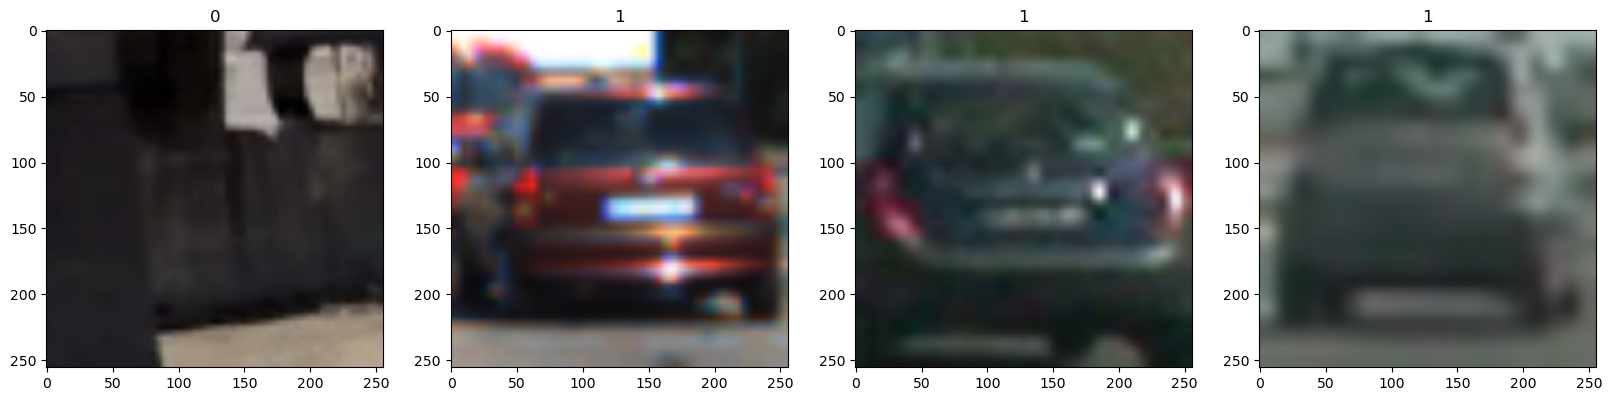

In [77]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4. Preprocesamos la data

In [78]:
# Escalar la data
data = data.map(lambda x,y: (x/255, y))
# x representan nuestras imagenes
# y los labels, 0 o 1 por eso ese no tiene que cambiar

In [79]:
# Obtenemos un lote de nuestra data escalada
batch = data.as_numpy_iterator().next()

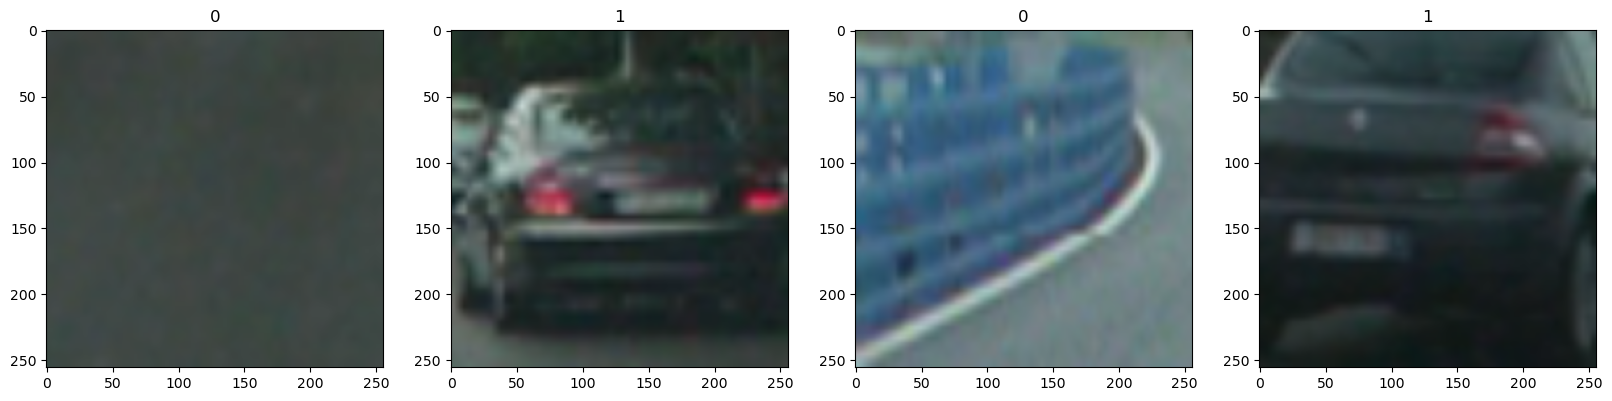

In [80]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [81]:
# Veamos el tamaño de nuestra data
len(data)

555

In [82]:
# Dividimos correctamente la data para entrenamiento y testeo
# Usaremos el 70% de nuestra data para entrenamiento
train_size = int(len(data)*.7)
# Usaremos el 20% de nuestra data para validación
val_size = int(len(data)*.2)
#Usaremos el 10% de nuestra data para testearlo
test_size = int(len(data)*.1)+1

In [83]:
train_size + val_size + test_size

555

In [84]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [85]:
len(train) + len(val) + len(test)

555

5.Crear el modelo Deep Learning

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [87]:
model = Sequential()

In [88]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [89]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [90]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

6. Entrenar la red neuronal

In [91]:
logdir='logs'

In [92]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [93]:
hist = model.fit(train, epochs=3, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/3
388/388 [==============================] - 19s 49ms/step - loss: 0.3460 - accuracy: 0.8473 - val_loss: 0.3738 - val_accuracy: 0.8637
Epoch 2/3
388/388 [==============================] - 18s 47ms/step - loss: 0.1347 - accuracy: 0.9495 - val_loss: 0.0734 - val_accuracy: 0.9713
Epoch 3/3
388/388 [==============================] - 19s 48ms/step - loss: 0.0785 - accuracy: 0.9734 - val_loss: 0.0982 - val_accuracy: 0.9794


7.Plot Performance

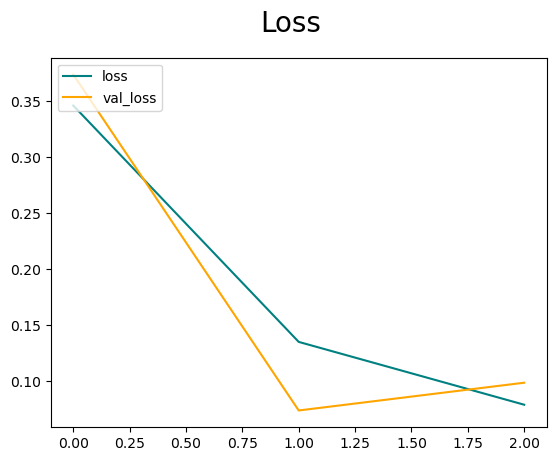

In [94]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

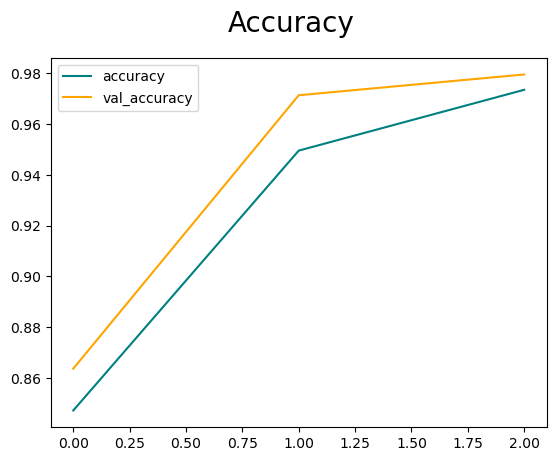

In [95]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

8.Evaluar

In [96]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [97]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [98]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 16ms/step


In [99]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.959695, shape=(), dtype=float32) tf.Tensor(0.981069, shape=(), dtype=float32) tf.Tensor(0.9698661, shape=(), dtype=float32)


9.Testear

In [100]:
import cv2

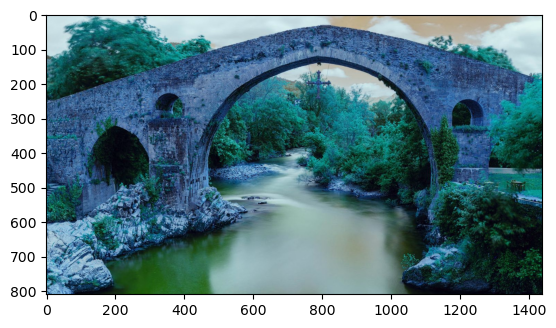

In [116]:
img = cv2.imread('puente.jpg')
plt.imshow(img)
plt.show()

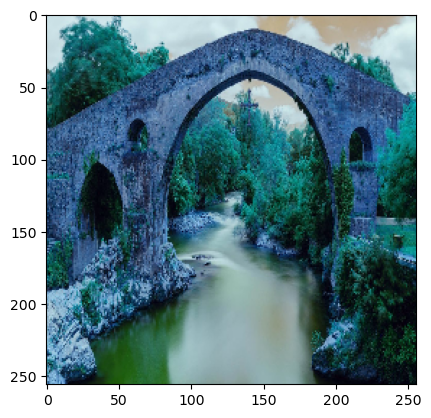

In [117]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [118]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 17ms/step


In [119]:
yhat

array([[2.6568884e-07]], dtype=float32)

In [120]:
if yhat > 0.5: 
    print(f'Predicted class is Vehicle')
else:
    print(f'Predicted class is a Non-vehicle')

Predicted class is a Non-vehicle


10. Guardar el modelo

In [121]:
from tensorflow.keras.models import load_model

In [122]:
model.save(os.path.join('models','imageclassifier_for_vehicles.h5'))

In [124]:
new_model = load_model('models/imageclassifier_for_vehicles.h5')

In [125]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 60ms/step


array([[2.6568884e-07]], dtype=float32)